# LIME<br>


## Model


<div>Train a Random Forest model to be used as `PredictionProvider` by the LIME explainer).<br></div>


In [1]:
import ml.smile.data.Loader
import smile.data.{DataFrame, Tuple}

We will use the *credit bias* dataset in the notebook. We will also restrict our model to two inputs (`Amount` and `LoanDuration`) and one output (`PaidLoan`) for easier visualisation.<br>

In [3]:
val df = Loader.csv(Loader.homeRelativePath("data/credit_bias-train.csv").toString)
val subset: DataFrame = df.select("Amount", "LoanDuration", "PaidLoan")

In [4]:
subset.summary

[column: String, count: long, min: double, avg: double, max: double]
+------------+-----+----+-----------+-----+
|      column|count| min|        avg|  max|
+------------+-----+----+-----------+-----+
|      Amount|58003|6.39|2242.612586|10632|
|LoanDura…

We will also use the range of the inputs as the search boundaries for the counterfactual search.

Let's train a Smile random forest with the default settings.<br>




In [6]:
import smile.data.formula.Formula
import smile.classification.RandomForest
import smile.data.`type`.{DataTypes, StructField}

val formula: Formula = Formula.lhs("PaidLoan")
val model = RandomForest.fit(formula, subset)

In [25]:
import ml.smile.providers.RandomForestProvider

val randomForest = new RandomForestProvider(formula, subset)

In [16]:
import org.kie.kogito.explainability.model._

val amount = 50
val duration = 22

val features = List(
    FeatureFactory.newNumericalFeature("Amount", amount),
    FeatureFactory.newNumericalFeature("LoanDuration", duration),
)


In [17]:
import ml.trusty.LIME

val limeExplainer = new LIME(randomForest, seed = 34, nPerturbations = 1, nSamples = 1000)

We can the CF returns a loan application with a slightly longer duration in order to be classified as "will pay".




In [19]:
val saliencies = limeExplainer.explain(features)

In [26]:
import scala.jdk.CollectionConverters._

val result = saliencies.get("PaidLoan").getPerFeatureImportance.asScala.map(importance => {
    (importance.getScore, importance.getFeature.getName)
})
val scores = result.map(_._1).toArray
val names = result.map(_._2).toArray

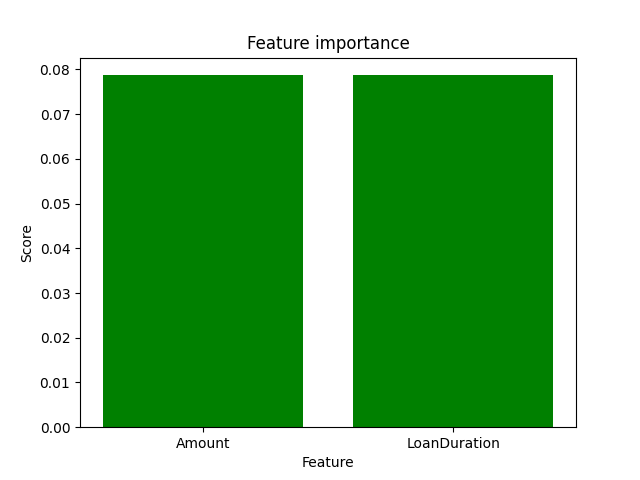

In [27]:
import matplotlib.pyplot as plt

names_pos = [i for i, _ in enumerate(names)]

plt.bar(names_pos, scores, color='green')
plt.xlabel("Feature")
plt.ylabel("Score")
plt.title("Feature importance")

plt.xticks(names_pos, names)

plt.show()